In [2]:
import osmnx as ox
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import networkx as nx
import json
import os
import nx_parallel as nxp

# # enabling networkx's config for nx-parallel
# nx.config.backends.parallel.active = True

# # setting `n_jobs` (by default, `n_jobs=None`)
# nx.config.backends.parallel.n_jobs = 4

In [ ]:
G = ox.graph_from_place("Williamson County, TN", network_type='drive', simplify=True)

In [ ]:
# First, add edge speeds
G = ox.routing.add_edge_speeds(G)

# Then, add edge travel times
G = ox.routing.add_edge_travel_times(G)

In [ ]:
print("Graph has been created with the following properties:")
print("Number of edges:", len(G.edges))
print("Number of nodes:", len(G.nodes))

In [ ]:
ox.plot_graph(G, node_size=0, edge_linewidth=0.5, edge_color='black', bgcolor='white', show=False, save=True, filepath='williamson_county_tn.png')

In [ ]:
# Now, let's find the shortest path between two random nodes in the graph
# generate random source and target nodes
source = random.choice(list(G.nodes))
target = random.choice(list(G.nodes))
r = nx.shortest_path(G, source, target)
print(len(r), "nodes in the route from", source, "to", target)
ox.plot_graph_route(G, r, node_size=0, edge_linewidth=0.5, edge_color='black', bgcolor='white', show=True)

In [ ]:
# get an edge between two nodes
edge = G.get_edge_data(r[0], r[1])
edge

In [ ]:
# how to get travel time given length and speed
length = edge[0]['length']
speed = edge[0]['speed_kph']
travel_time = length / (speed * 1000 / 3600)  # convert speed from kph to m/s
print(f"Travel time from {r[0]} to  {r[1]} is {travel_time:.2f} seconds.")

In [ ]:
# getting all pairs shortest paths with travel time as weight
# This will compute the shortest path between all pairs of nodes in the graph
# using the travel time as the weight for the edges.
# Note: This can be computationally expensive for large graphs.
# If you only need the shortest path between two specific nodes,
# it's more efficient to use nx.dijkstra_path or nx.shortest_path directly.
# For example, to find the shortest path from source to target:
# r = nx.shortest_path(G, source, target, weight='travel_time')
# or to find the shortest path using Dijkstra's algorithm:

# Using Dijkstra's algorithm to find the shortest path from source to target
r = nx.dijkstra_path(G, source, target, weight='travel_time')

In [ ]:
# all pairs shortest paths with travel time as weight
# Create index mapping
nodes = list(G.nodes())
# you need to save this node_to_idx mapping if you want to use it later
node_to_idx = {node: idx for idx, node in enumerate(nodes)}
# save dictionary to json
with open('williamson_county_tn_node_to_idx.json', 'w') as f:
    json.dump(node_to_idx, f)

n = len(nodes)
matrix = [[float('inf')] * n for _ in range(n)]  # initialize matrix with infinities

# Set diagonal to 0
for i in range(n):
    matrix[i][i] = 0

paths = nx.all_pairs_dijkstra_path(G, weight='travel_time', cutoff=300, backend="parallel")

for source, target_dict in paths:
    for target, path in target_dict.items():
        i = node_to_idx[source]
        j = node_to_idx[target]

        # Compute path length from edge lengths
        length = 0
        for u, v in zip(path[:-1], path[1:]):
            length += G[u][v][0]['length']  # adjust edge key/index if multi-edge

        matrix[i][j] = length
#save matrix
np.save('williamson_county_tn_shortest_paths.npy', matrix)

In [13]:
# 2 random points inside williamson county, tn
point1 = (-86.789, 35.771)  # Example coordinates
point2 = (-86.789, 35.771)  # Example coordinates

/Users/jose/Developer/git/venv310/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jose/Developer/git/venv310/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jose/Developer/git/venv310/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jose/Developer/git/venv310/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be rem

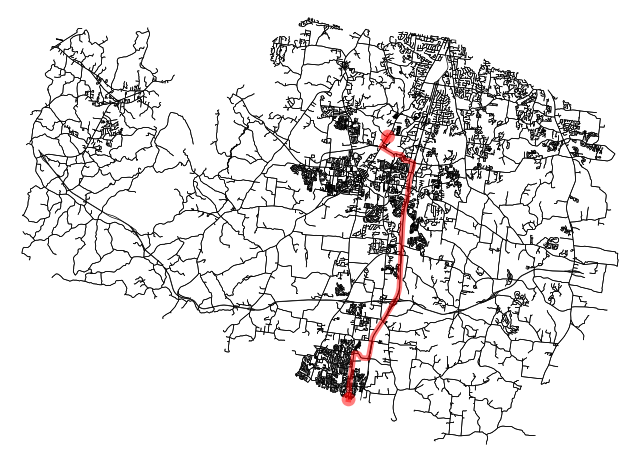

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [16]:
# nearest nodes
nearest_node_o = ox.nearest_nodes(G, Y=35.95423497009301, X=-86.84558305549878)
nearest_node_d = ox.nearest_nodes(G, Y=35.736447594139854, X=-86.88992113617955)

# route
r = nx.dijkstra_path(G, nearest_node_o, nearest_node_d, weight='travel_time')
# plot the route
ox.plot_graph_route(G, r, node_size=0, edge_linewidth=0.5, edge_color='black', bgcolor='white', show=True)

In [ ]:
# # day inrix
# 1. map inrix segments to osmnx edges
# 2. add the weights to osmnx
# 3. solve all pairs shortest path or 
# all stops pairs shortest path

# Plotting speeds
0. Make sure you run mapping inrix to osm.py to get the correct mapping.
    * See [its readme.](https://github.com/jptalusan/geospatial_mapper/blob/main/README.md)
1. identify the osm ids of a bus route (you can map each stop to the nearest node and iterate through each pair of nodes/stops to get to the school to find the sequence of nodes).
2. get those segments and speeds across time
3. plot x is time, y is segments from depot to school, value is speed. 
    * you can also plot when the incident occured and at what segment
4. Data should look something like [this](https://acoursey3.github.io/ft-aed/)